
## Writing your own Feature Transformers
Link: https://scikit-learn.org/stable/data_transforms.html

Implement two functions: `fit` and `transform`:
1. `fit` computes any necessary parameters of the transformer, based on the data-set (e.g., min/max/average), and returns the transformer itself once complete.
2. `transform` takes in a data-set and performs the transformation on that data, returning the new version.
There are a number of existing transformers for standard tasks; here, we show how to write a few of our own, simple transformers.

(Based on work by [Dr. Mike Hughes](https://www.michaelchughes.com).)


In [1]:
# imports and setup
import numpy as np
from scipy.special import logsumexp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import sklearn.metrics
import sklearn.linear_model
import sklearn.tree
import sklearn.neighbors
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
np.set_printoptions(suppress=True, precision=2)
plt.style.use('seaborn') # pretty matplotlib plots

sns.set(font_scale=2)

## Toy Dataset

In [2]:
C = 50 # num examples per class
N = 2 * C # num examples total
random_state = np.random.RandomState(0)
x_pos_C2 = 0.5 * random_state.randn(C, 2)
x_neg_M2 = 5.0 * random_state.randn(100 * C, 2)
radius_M = np.sqrt(np.sum(np.square(x_neg_M2), axis=1))
fits_ring_M = np.logical_and(radius_M >= 1.8, radius_M <= 2.5)
x_neg_C2 = x_neg_M2[fits_ring_M][:C]

x_N2 = np.vstack([x_neg_C2, x_pos_C2])
y_N = np.hstack([np.zeros(C), 1.0 * np.ones(C)])

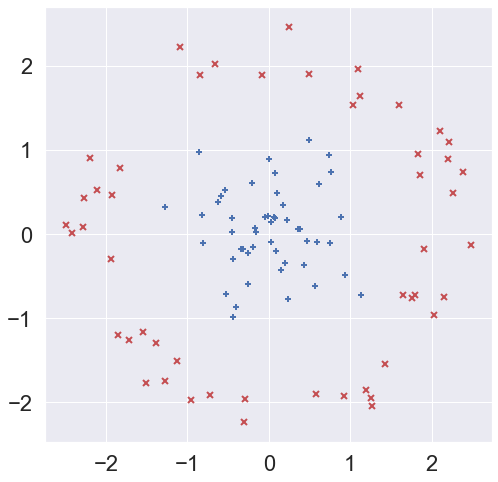

In [3]:
plt.figure(figsize=(8,8))
plt.plot(x_N2[y_N == 1,0], x_N2[y_N == 1,1], color='b', marker='+', ls='', mew=2);
plt.plot(x_N2[y_N == 0,0], x_N2[y_N == 0,1], color='r', marker='x', ls='', mew=2);

## Sum Feature Extractor

A simple transformer: takes N-dimensional data and transforms to 1-dimensional data by summing all features into a single value.

In [4]:
class SumFeatureExtractor(BaseEstimator, TransformerMixin):
    """ Extracts *sum* of input feature vector as new feature
    """

    def fit(self, x_NF, y_N=None):
        """ Nothing happens, as this transform has no trainable parameters;
            simply sets the number of features parameter and returns self.
        """
        self.n_input_features_ = x_NF.shape[1]
        return self
    
    
    def transform(self, x_NF, y_N=None):
        """ Sum all feature values into a new feature column
        Returns
        -------
        feat : 2D array, size N x 1
            One feature extracted for each example
        """
        return np.sum(x_NF, axis=1)[:,np.newaxis]

    def get_feature_names(self):
        return ['sum']

In [5]:
t = SumFeatureExtractor()

# Fitting to data does not produce any changes.
t.fit(x_N2)

x_N2[:5]

array([[-2.28,  0.09],
       [-1.85, -1.2 ],
       [-0.09,  1.9 ],
       [-1.92,  0.47],
       [-1.82,  0.78]])

In [6]:
t.transform(x_N2[:5])

array([[-2.19],
       [-3.04],
       [ 1.81],
       [-1.45],
       [-1.04]])

In [7]:
# Note that as written we don't actually change original data (this is good practice!):
x_N2[:5]

array([[-2.28,  0.09],
       [-1.85, -1.2 ],
       [-0.09,  1.9 ],
       [-1.92,  0.47],
       [-1.82,  0.78]])

In [8]:
feat_NG = t.transform(x_N2)

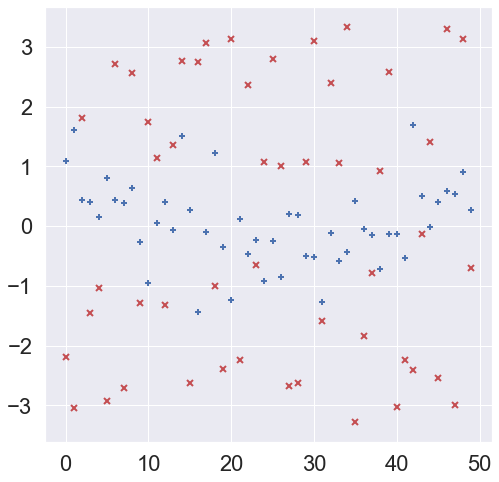

In [9]:
plt.figure(figsize=(8,8))
plt.plot(feat_NG[y_N == 1], color='b', marker='+', ls='', mew=2);
plt.plot(feat_NG[y_N == 0], color='r', marker='x', ls='', mew=2);

## Square Feature Extractor

In [10]:
class SquareFeatureExtractor(BaseEstimator, TransformerMixin):
    """ Squares each feature in the input vector
    """

    def fit(self, x_NF, y_N=None):
        """ Nothing happens, as this transform has no trainable parameters;
            simply sets the number of features parameter and returns self.
        """
        self.n_input_features_ = x_NF.shape[1]
        return self
    
    def transform(self, x_NF, y_N=None):
        """ 
        Squares each feature in original data
        Returns
        -------
        feat_NF : 2D array, size N x F
            F features extracted for each example
        """
        return np.square(x_NF)
    
    def get_feature_names(self):
        return ['squared_x_%d' % a for a in range(self.n_input_features_)]

Text(0, 0.5, '(x_2)^2')

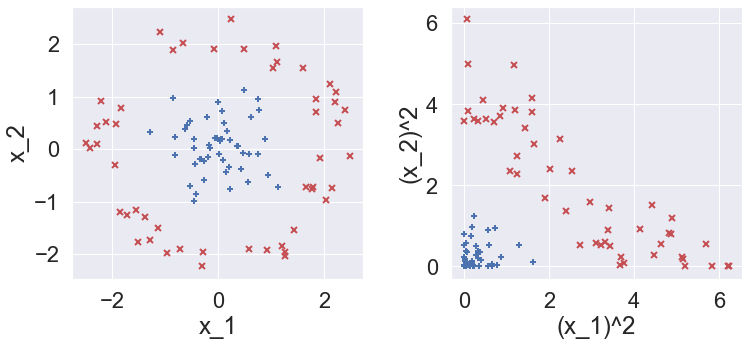

In [11]:
t = SquareFeatureExtractor()
feat_N2 = t.transform(x_N2)

fig, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)
axgrid[0].plot(x_N2[y_N == 1,0], x_N2[y_N == 1,1], color='b', marker='+', ls='', mew=2);
axgrid[0].plot(x_N2[y_N == 0,0], x_N2[y_N == 0,1], color='r', marker='x', ls='', mew=2);
axgrid[0].set_xlabel("x_1")
axgrid[0].set_ylabel("x_2")

axgrid[1].plot(feat_N2[y_N == 1,0], feat_N2[y_N == 1,1], color='b', marker='+', ls='', mew=2);
axgrid[1].plot(feat_N2[y_N == 0,0], feat_N2[y_N == 0,1], color='r', marker='x', ls='', mew=2);
axgrid[1].set_xlabel("(x_1)^2")
axgrid[1].set_ylabel("(x_2)^2")


## MinMaxFeatureRescalar : A Transformer with trainable parameters

In [12]:
class MinMaxFeatureRescaler(BaseEstimator, TransformerMixin):
    """ Rescales each feature column to be within [0, 1], using training data min/max
    """
    
    def fit(self, x_NF, y_N=None):
        """ Computes the min/max values needed for later scaling.
            Returns self with values saved.
        """
        self.n_input_features_ = x_NF.shape[1]
        self.min_1F_ = np.min(x_NF, axis=0, keepdims=1)
        self.max_1F_ = np.max(x_NF, axis=0, keepdims=1)
        return self

    def transform(self, x_NF, y_N=None):
        """ Scales each feature to the new interval [0,1];
            same number of features after transform, but now
            restricted in range.
        """
        feat_NF = ((x_NF - self.min_1F_)
            / (self.max_1F_ - self.min_1F_))
        return feat_NF

    def get_feature_names(self):
        return ['rescaled_x_%d' % a for a in range(self.n_input_features_)]

In [13]:
t = MinMaxFeatureRescaler()
t.fit(x_N2)

MinMaxFeatureRescaler()

In [14]:
x_N2[:5]

array([[-2.28,  0.09],
       [-1.85, -1.2 ],
       [-0.09,  1.9 ],
       [-1.92,  0.47],
       [-1.82,  0.78]])

In [15]:
t.transform(x_N2)[:5]

array([[0.04, 0.49],
       [0.13, 0.22],
       [0.48, 0.88],
       [0.11, 0.58],
       [0.13, 0.64]])

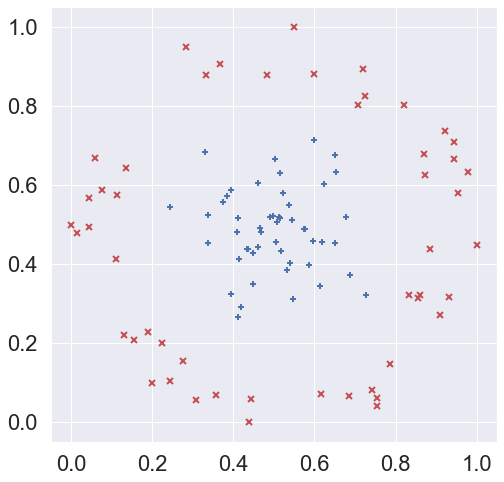

In [16]:
plt.figure(figsize=(8,8))
feat_N2 = t.transform(x_N2)
plt.plot(feat_N2[y_N == 1,0], feat_N2[y_N == 1,1], color='b', marker='+', ls='', mew=2);
plt.plot(feat_N2[y_N == 0,0], feat_N2[y_N == 0,1], color='r', marker='x', ls='', mew=2);

## Feature union

Once a set of transformers are built, they can be combined.  This code creates a *union* of features, so that each data-ooint is transformed to have *all* the transforms applied to it (in parallel, not in sequence).

In [17]:
from sklearn.pipeline import FeatureUnion

In [18]:
union_transformer = FeatureUnion(transformer_list=[
    ('sum_x', SumFeatureExtractor()),
    ('square_x', SquareFeatureExtractor()),
    ('rescale_x', MinMaxFeatureRescaler()),
])

In [19]:
union_transformer.fit(x_N2);
union_transformer.transform(x_N2)[:3]

array([[-2.19,  5.19,  0.01,  0.04,  0.49],
       [-3.04,  3.41,  1.43,  0.13,  0.22],
       [ 1.81,  0.01,  3.59,  0.48,  0.88]])

In [20]:
union_transformer.get_feature_names()

['sum_x__sum',
 'square_x__squared_x_0',
 'square_x__squared_x_1',
 'rescale_x__rescaled_x_0',
 'rescale_x__rescaled_x_1']